In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.rcParams['figure.figsize'] = (30, 10)
plt.style.use('ggplot')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(threshold=sys.maxsize)#np.set_printoptions(threshold=sys.maxsize)

import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
import re
import itertools
from pprint import pprint

In [2]:
df_vigil = pd.read_csv('../Cleaner/el vigil 170902018.txt_data_cleaned.csv', index_col=0)
df_vaquerias = pd.read_csv('../Cleaner/000960_Vaquerias_Jalisco_meas_2017.09.04-2017.10.03.txt_data_cleaned.csv', index_col=0)
df = pd.read_csv('../Cleaner/001082__meas_2017.10.03-2018.01.23.txt_data_cleaned.csv', index_col=0) #igual a df_vaquerias
df_ech1 = pd.read_csv('../Cleaner/ech1 18092018.txt_data_cleaned.csv', index_col=0)

df_vigil = df_vigil.rename(columns={'Date & Time Stamp': 'timestamp'})
df_vaquerias = df_vaquerias.rename(columns={'Date & Time Stamp': 'timestamp'})
df = df.rename(columns={'Date & Time Stamp': 'timestamp'})
df_ech1 = df_ech1.rename(columns={'Date & Time Stamp': 'timestamp'})


dfs = [df_vigil, df_vaquerias, df, df_ech1]

In [3]:
def construct_stats(df, sensor='anem', func='correlation', func_column='Avg', window = 10):
    
    str_sensor = ['timestamp']
    str_sensor.append(sensor)
    
    str_default_channels = ['CH1', 'CH2', 'CH3', 'CH13', 'CH14'] if sensor == 'anem' else ['CH7', 'CH8']
    
    try:
        
        ch_sensors = [x for x in df.columns if any(i.lower() in x.lower() for i in str_sensor)]
        if len(ch_sensors) < 2:
            raise ValueError
            
    except ValueError:
        print(f'Las columnas del set de datos no especifican si el sensor es un {sensor}, se toma por default {str_default_channels} como {sensor}')
        ch_sensors = ['timestamp']
        for c in str_default_channels:
            ch_sensors.append(c + 'Avg')
            ch_sensors.append(c + 'SD')
            ch_sensors.append(c + 'Max')
            ch_sensors.append(c + 'Min')
            
            
    df_sensors = df.loc[:, ch_sensors]
    
    if sensor == 'vane':
        func_column = '_deg_cos'
        df_sensors = df_sensors.iloc[:, df_sensors.columns.str.contains('Avg')]
        for col in df_sensors.columns:
            df_sensors[str(col) + '_cos'] = np.sin(np.deg2rad(df_sensors[col])) 
    
    
    for x in itertools.combinations(df_sensors.columns[~df_sensors.columns.str.contains('timestamp')], 2):
        for i in func_column:
            if (str(i) in x[0] and str(i) in x[1]):
                
                # Fractions
                if (func == 'ratio') or (func == 'all'):
                    df_sensors[str(x[0] + 'VS' + x[1] + '_ratio')] = df_sensors[x[0]] / df_sensors[x[1]]
                
                
                # Rolling correlations           
                if (func == 'correlation') or (func == 'all'):
                    rolling_correlation = df_sensors[x[0]].rolling(window).corr(df_sensors[x[1]])
                    df_sensors[str(x[0] + 'VS' + x[1] + '_correlation')] = rolling_correlation.values

                # Difference
                if (func == 'diff') or (func == 'all'):
                    if '_cos' in x[0] and '_cos' in x[1]:
                        df_sensors[str(x[0] + 'VS' + x[1] + '_diff')] = df_sensors[x[0]] - df_sensors[x[1]]
                
            
    return df_sensors

In [4]:
def sensor_anomalies(df, func='correlation', limit=10):
    
    dict_bad_anemometer = {}
    columns = []
    
    if (func == 'correlation') or (func == 'all'):
        columns.extend(df.columns[df.columns.str.contains('_correlation')])
        
    if (func == 'ratio') or (func == 'all'):
        columns.extend(df.columns[df.columns.str.contains('_ratio')])
        
    if (func == 'diff') or (func == 'all'):
        columns.extend(df.columns[df.columns.str.contains('_diff')])
    
    for col in columns:
        #if len(df[df[col] > limit].index.values) > 0 | len(df[df[col] < (-limit)].index.values) > 0 :
        if len(df[df[col] > limit].index.values) > 0:
            dict_bad_anemometer[col] = df[(df[col] > limit) | (df[col] < (-limit))].index.values
            #dict_bad_anemometer[col] = df[(df[col] > limit)].index.values
        
    return dict_bad_anemometer

In [5]:
stats_dict = {}

for idx, df in enumerate(dfs):
    stats_dict[idx] = construct_stats(df, sensor='vane', func='diff')

Las columnas del set de datos no especifican si el sensor es un vane, se toma por default ['CH7', 'CH8'] como vane
Las columnas del set de datos no especifican si el sensor es un vane, se toma por default ['CH7', 'CH8'] como vane


In [6]:
anomalies_dict = {}

for idx, df in enumerate(stats_dict):
    anomalies_dict[idx] = sensor_anomalies(stats_dict[idx], 'diff', limit=.5)

In [7]:
anomalies_dict[0]

{'CH7Avg_cosVSCH8Avg_cos_diff': array([   96,    97,    98,    99,   100,   345,   359,   375,   376,
         1330,  1331,  1333,  1353,  1354,  1384,  1385,  1386,  1387,
         1388,  1389,  1390,  1523,  1524,  1525,  1535,  1536,  1595,
         1596,  1613,  1615,  1616,  1617,  1618,  1619,  1620,  1621,
         1622,  1623,  1624,  1625,  1626,  1627,  1628,  1629,  1630,
         1631,  1632,  1633,  1634,  1635,  1636,  1637,  1638,  1639,
         1649,  1652,  1654,  1655,  1656,  1657,  1658,  1661,  1663,
         1664,  1665,  1669,  1670,  1671,  1672,  1673,  1674,  1675,
         1676,  1677,  1678,  1679,  1680,  1710,  1870,  1900,  1906,
         1912,  2043,  2044,  2045,  2046,  2047,  2048,  2049,  2050,
         2155,  2774,  2776,  2777,  2779,  2781,  2782,  2783,  2787,
         2790,  2794,  2990,  3375,  3376,  3377,  3513,  3571,  4318,
         4320,  4321,  4322,  4323,  4327,  4396,  4466,  4470,  4471,
         4477,  4478,  4484,  4486,  5058,  50

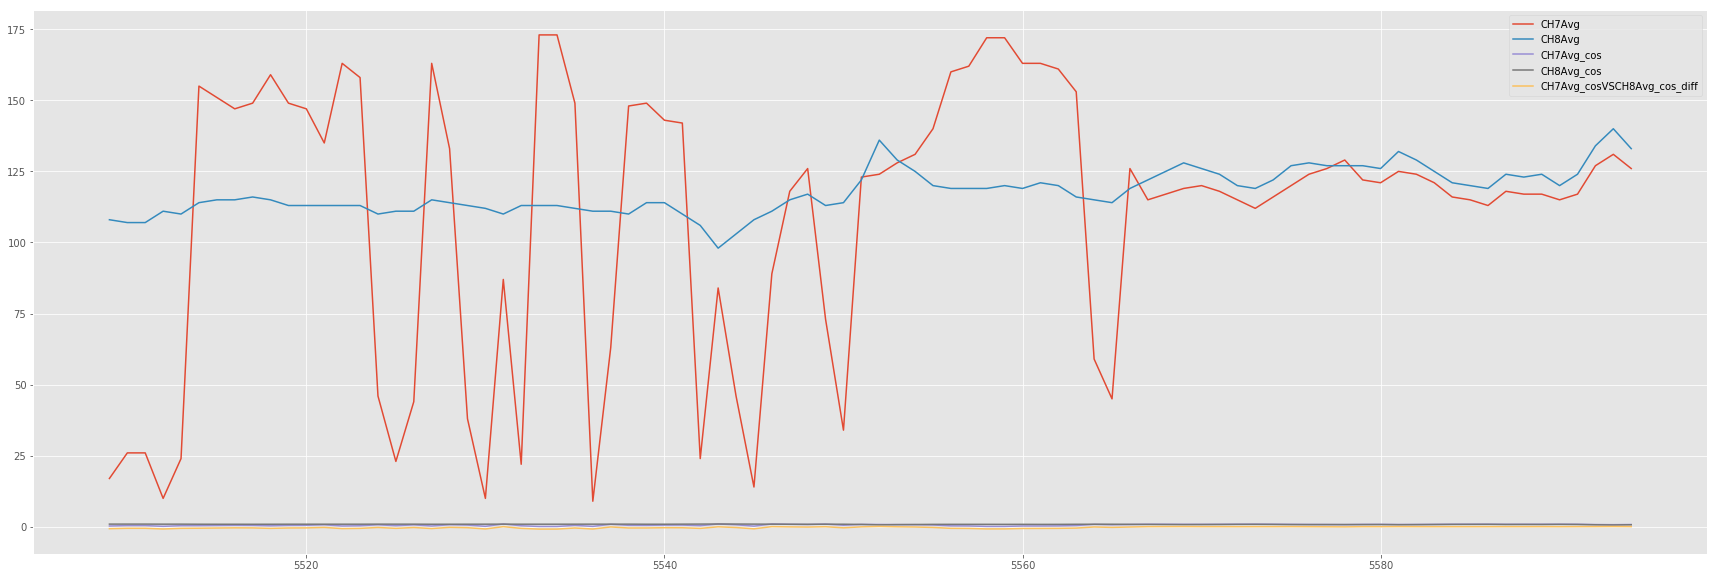

In [13]:
stats_dict[0][5509:5595].plot()

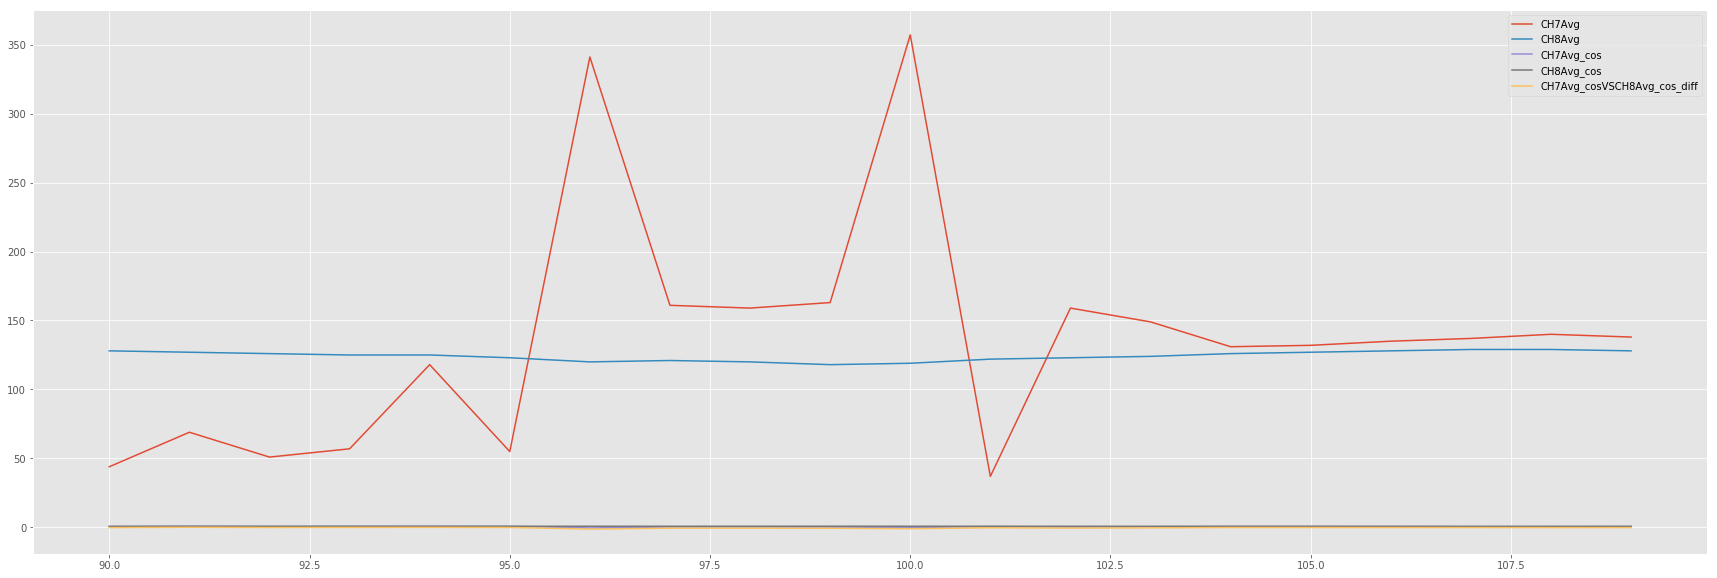

In [43]:
stats_dict[0][90:110].plot()

In [44]:
stats_dict[0][90:110]

,CH7Avg,CH8Avg,CH7Avg_cos,CH8Avg_cos,CH7Avg_cosVSCH8Avg_cos_diff
90,44.0,128.0,0.694658,0.788011,-0.093352
91,69.0,127.0,0.933580,0.798636,0.134945
92,51.0,126.0,0.777146,0.809017,-0.031871
93,57.0,125.0,0.838671,0.819152,0.019519
94,118.0,125.0,0.882948,0.819152,0.063796
95,55.0,123.0,0.819152,0.838671,-0.019519
96,341.0,120.0,-0.325568,0.866025,-1.191594
97,161.0,121.0,0.325568,0.857167,-0.531599
98,159.0,120.0,0.358368,0.866025,-0.507657
99,163.0,118.0,0.292372,0.882948,-0.590576


In [30]:
anomalies_dict[3]

{'CH7Avg_cosVSCH8Avg_cos_diff': array([    2,     3,     4,     6,     7,     8,     9,    10,    11,
           37,    38,    39,   552,  1986,  1987,  1988,  2234,  2236,
         2278,  2279,  2280,  2281,  2282,  2283,  2284,  2285,  2286,
         3834,  3839,  7538,  7539,  7560,  7589, 12075, 12077, 12078,
        12298, 12301, 12322, 12331, 12372, 14101, 14122, 14123, 14124,
        14125, 14126, 14127, 14193, 14432, 14433, 14434, 14435, 14436,
        14437, 14438, 14439, 14440, 14441, 14442, 14443, 14444, 14445,
        14446, 14447, 14448, 14449, 14450, 14451, 14452, 14453, 14454,
        14455, 14842, 14843, 14844, 14845, 14846, 14847, 14848, 14849,
        14850, 14851, 14852, 14853, 14854, 14855, 14856, 15648, 17800,
        17855, 17856, 17857, 17858, 17859, 17860, 17861, 17862, 17863,
        17864, 17865, 17866, 17867, 17914, 17915, 17916, 17917, 17918,
        18256, 19286, 19994, 19995, 19996, 19997, 19998, 19999, 20000,
        20452, 20453, 20454, 20455, 20456, 204

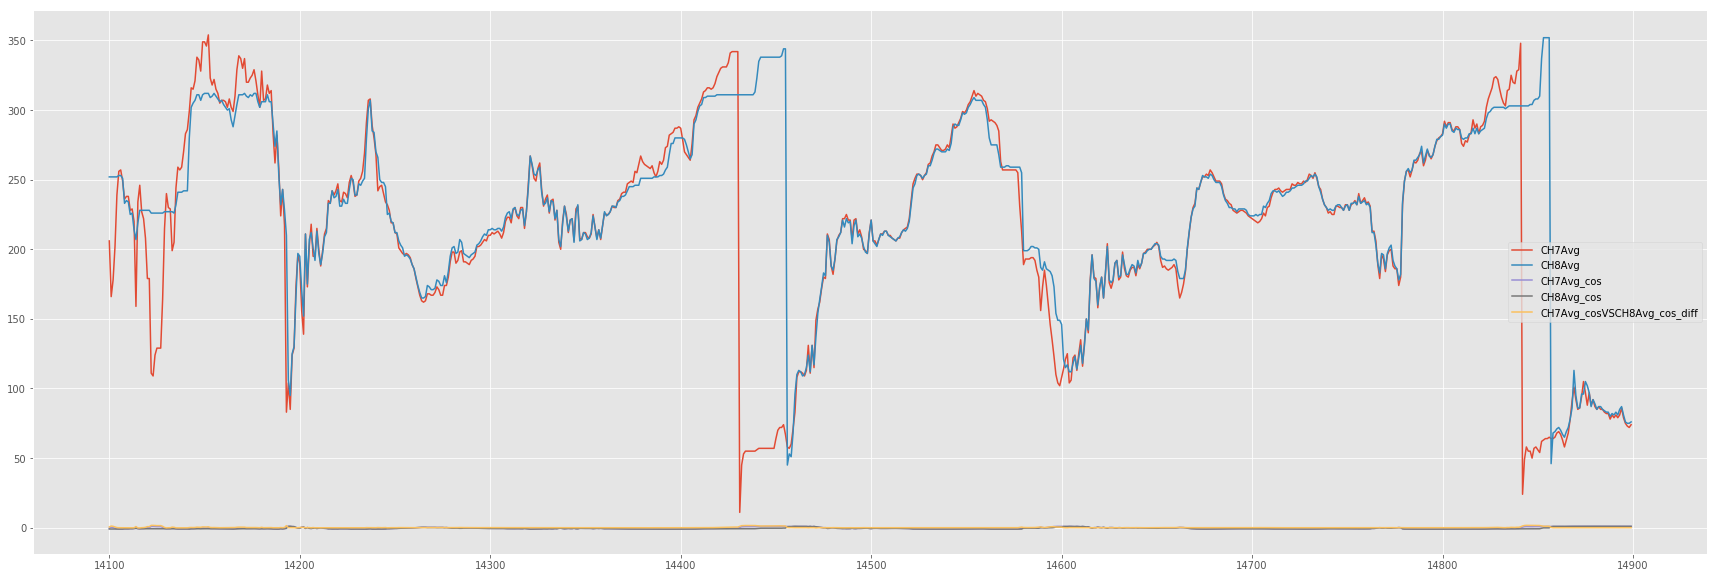

In [34]:
stats_dict[3][14100:14900].plot()